In [1054]:
import numpy as np
import matplotlib.pyplot as plt

import sys, os
import h5py
sys.path.append('../')
import analysis_utils as utils

yale_colors = ['#00356b', '#286dc0', '#63aaff', '#4a4a4a']
utils.load_plotting_setting()

from scipy.signal import savgol_filter

In [1053]:
import importlib
importlib.reload(utils)

/Users/yuhan/work/nanospheres/impulse_analysis/analysis_notebooks/../analysis_utils.py:459: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(xx*amp2kev, gauss(xx*amp2kev, *gps_normalized), label=f'{pulseamps[i]} keV (noise), $\sigma$ = {gps_normalized[2]:.1f} keV', color=color)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_notebooks/../analysis_utils.py:461: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(xx*amp2kev, gauss(xx*amp2kev, *gps_normalized), label=f'{pulseamps[i]} keV, $\sigma$ = {gps_normalized[2]:.1f} keV', color=color)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_notebooks/../analysis_utils.py:466: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(xx, gauss(xx, *gps[i]), label=f'{pulseamps[i]} keV (noise), $\sigma$ = {gps[i][2]:.1f} keV', color=color)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_notebooks/../analysis_utils.py:468: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(xx, gauss(xx, *gps[i]), label=f'{pulseamps

<module 'analysis_utils' from '/Users/yuhan/work/nanospheres/impulse_analysis/analysis_notebooks/../analysis_utils.py'>

In [531]:
from matplotlib.ticker import LogLocator, NullFormatter, MultipleLocator
from scipy.optimize import curve_fit

In [722]:
file = '/Users/yuhan/work/nanospheres/data/dm_data_processed/sphere_20241202/sphere_20241202_recon_all.h5py'
with h5py.File(file, 'r') as fout:
    g = fout['recon_data_all']
    hist = g['hist'][:]
    n_window = g['hist'].attrs['n_windows']
    scaling = g['hist'].attrs['scaling']

    rate_all = g['rate_hist'][:]
    rate_all_err = g['rate_hist_err'][:]
    bc = g['bc'][:]

    time_all = g.attrs['time_hours']

    fout.close()

from scipy.special import erf
def func2(x, z, f):
    return 0.5 * erf((x - z) * f) + 0.5

file = '/Users/yuhan/work/nanospheres/data/pulse_calibration_processed/sphere_20241202_calibration_all.h5py'
with h5py.File(file, 'r') as fout:
    g = fout['calibration_data_processed']
    eff_coefs = g['sig_efficiency_fit_params'][:]

    fout.close()

In [180]:
xx = np.linspace(1, 9950, 9950)
ff = func2(xx, *eff_coefs)

# Signal efficiency for each bin
eff_binned = np.mean(np.reshape(ff, (199, 50)), axis=1)
eff_binned[bc < 800] = 0  # Choose a 800 keV analysis threshold

In [940]:
from scipy.special import zeta

def func_fit(x, alpha, sigma, xmin, a):
    eff = func2(x, *eff_coefs)
    total_amp = 1 / (2e-6 * 25)
    
    gaus  = (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-1 * x**2 / (2 * sigma**2))
    power_law = np.power(x, -1*a) / zeta(a, xmin)

    return np.log(total_amp * (alpha * gaus + (1 - alpha) * eff * power_law))

def func_fit_expo(x, alpha, sigma, xi):
    eff = func2(x, *eff_coefs)

    # (1 s)/(time per search)
    # no need to divide by bin width because the function
    # is continuous and normalize differently
    total_amp = 1 / (2e-6 * 25)
    
    # Assume zero mean
    # Factor of two because we only have half gaussian
    gaus  = 2 * (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-1 * x**2 / (2 * sigma**2))

    # Re-normalize exponential after applying efficiency correction
    xx = np.linspace(0, 50000, 50000)
    eff_xx = func2(xx, *eff_coefs)
    expo_corrected_norm = np.trapz(eff_xx * np.exp(-1 * xx / xi) / xi, xx)

    expo_corrected = eff * (np.exp(-1 * x / xi) / xi) / expo_corrected_norm

    return np.log(total_amp * (alpha * gaus + (1 - alpha) * expo_corrected))


In [1118]:
idx_fit = np.logical_and(np.logical_and(bc > 800, hist > 0), bc<3500)

popt_power, pcov_power = curve_fit(func_fit, bc[idx_fit], np.log(rate_all[idx_fit]), p0=[0.99, 287, 800, 10], sigma=np.log(rate_all_err[idx_fit]),
                       bounds=([0.5, 200, 100, 2], [1, 400, 1800, 20]), maxfev=5000)

popt_expo, pcov_expo = curve_fit(func_fit_expo, bc[idx_fit], np.log(rate_all[idx_fit]),
                                 p0=[0.998, 287, 250], sigma=np.log(rate_all_err[idx_fit]),
                                 bounds=([0.9, 200, 100], [1, 400, 2000]), maxfev=5000)

In [1205]:
def gaus_corrected(x, mu, sigma):
    xx = np.linspace(0, 50000, 50000)
    gaus_corrected_norm = np.trapz((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-1 * (xx - mu)**2 / (2 * sigma**2)), xx)

    return (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-1 * (x - mu)**2 / (2 * sigma**2)) / gaus_corrected_norm

def half_gaus(x, sigma):
    return 2 * (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-1 * (x)**2 / (2 * sigma**2))

def expo_corrected(x, b, xi, eff_coefs=None):
    # Re-normalize exponential after applying efficiency correction 
    # and truncate from below
    xx = np.linspace(0, 50000, 50000)

    if eff_coefs is not None:
        eff_xx = func2(xx, *eff_coefs)
        expo_eff_truncated = eff_xx * np.exp(-1 * (xx) / xi) / xi
    else:
        expo_eff_truncated = np.exp(-1 * (xx) / xi) / xi
    expo_eff_truncated[xx < b] = 0

    expo_corrected_norm = np.trapz(expo_eff_truncated, xx)

    x = np.asarray(x)
    if eff_coefs is not None:
        eff_x = func2(x, *eff_coefs)
        ret = eff_x * np.exp(-1 * (x) / xi) / xi
    else:
        ret = np.exp(-1 * (x) / xi) / xi
    ret[x < b] = 0

    if ret.size == 1:
        return ret[0] / expo_corrected_norm
    else:
        return ret / expo_corrected_norm
    
def power_law_corrected(x, xmin, a, eff_coefs):
    xx = np.linspace(0, 50000, 50000)
    eff_xx = func2(xx, *eff_coefs)

    power_law_eff = eff_xx * np.power(xx, -1 * a) / zeta(a, xmin)
    power_law_eff[xx < xmin] = 0

    power_law_corrected_norm = np.trapz(power_law_eff, xx)

    x = np.asarray(x)
    eff_x = func2(x, *eff_coefs)
    
    ret = eff_x * np.power(x, -1 * a) / zeta(a, xmin)
    ret[x < xmin] = 0

    if ret.size == 1:
        return ret[0] / power_law_corrected_norm
    else:
        return ret / power_law_corrected_norm

def laplace_corrected(x, b, xi, eff_coefs):
    xx = np.linspace(0, 50000, 50000)
    eff_xx = func2(xx, *eff_coefs)

    laplace_eff = eff_xx * np.exp(-1 * np.abs(xx - b) / xi) / (2 * xi)
    laplace_corrected_norm = np.trapz(laplace_eff, xx)

    eff_x = func2(x, *eff_coefs)
    
    ret = eff_x * np.exp(-1 * np.abs(x - b) / xi) / (2 * xi)
    return ret / laplace_corrected_norm

def half_gaus_expo(x, b, sigma, xi, eff_coefs):
    xx = np.linspace(0, 50000, 50000)

    xx_low = xx[xx < b]
    _half_gaus = half_gaus(xx_low, sigma)

    xx_high = xx[xx > b]
    eff_xx = func2(xx_high, *eff_coefs)
    _expo_eff = eff_xx * np.exp(-1 * (xx_high) / xi) / xi

    func_all = np.empty_like(xx)
    func_all[xx < b] = _half_gaus
    func_all[xx > b] = _expo_eff
    _norm = np.trapz(func_all, xx)

    x = np.asarray(x)
    ret = np.empty_like(x)

    eff_x_high = func2(x[x>b], *eff_coefs)
    
    ret[x < b] = half_gaus(x[x<b], sigma)
    ret[x > b] = eff_x_high * np.exp(-1 * (x[x>b]) / xi) / xi

    if ret.size == 1:
        return ret[0] / _norm
    else:
        return ret / _norm

def half_gaus_mod(x, mu, m, n):
    xx = np.linspace(0, 50000, 50000)
    sigma = m * xx + n
    _norm = np.trapz((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-1 * (xx - mu)**2 / (2 * sigma**2)), xx)

    sigma_x = m * x + n
    return (1 / (np.sqrt(2 * np.pi) * sigma_x)) * np.exp(-1 * (x - mu)**2 / (2 * sigma_x**2)) / _norm

def half_gaus_mod_fixed(x, mu, sigma):
    xx = np.linspace(0, 50000, 50000)
    _norm = np.trapz((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-1 * (xx - mu)**2 / (2 * sigma**2)), xx)

    return (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-1 * (x - mu)**2 / (2 * sigma**2)) / _norm

In [1560]:
def nll(alpha, mu, m, n, b, xi, bc, hist, eff_coefs=None):
# def nll(alpha, mu, sigma, b, xi, bc, hist, eff_coefs=None):
    # idx = np.logical_and(bc > 800, bc < 3000)
    idx = bc > 800

    bi = bc[idx]
    ni = hist[idx]

    # Total number of count in the entire range
    ntot = np.sum(hist)

    # Expected number of count in each bin
    # fi = np.empty_like(ni, dtype=np.float64)
    # for i, bc in enumerate(bi):
    #     be_lower = bc - 25
    #     be_upper = bc + 25

    #     xx = np.linspace(be_lower, be_upper, 25)
    #     joint_pdf = alpha * half_gaus_mod(xx, mu, m, n) + (1 - alpha) * expo_corrected(xx, b, xi, eff_coefs=None)
    #     # joint_pdf = alpha * half_gaus_mod_fixed(xx, mu, sigma) + (1 - alpha) * expo_corrected(xx, b, xi=xi, eff_coefs=None)

    #     fi[i] = np.trapz(joint_pdf, xx)
    # mui = ntot * fi

    # Use only the central value of pdf
    # faster and avoid numerical issues from integration
    joint_pdf = alpha * half_gaus_mod(bi, mu, m, n) + (1 - alpha) * expo_corrected(bi, b, xi, eff_coefs=None)
    mui = ntot * joint_pdf * 50

    # third_term = np.asarray([0 if ni[i]==0 else ni[i] * np.log(ni[i] / mui[i]) for i in range(ni.size)])
    # return 2 * np.sum(mui - ni + third_term)

    return np.sum(np.nan_to_num(mui - ni * np.log(mui)))


In [1585]:
from scipy.optimize import minimize

ntot = np.sum(hist)
args = (bc, hist, None)
res = minimize(fun=lambda x: nll(*x, *args), x0=[0.9999, 200, 5e-2, 180, 1300, 200],
               method='COBYQA',
               bounds=[(0.99, 1), (0, 300), (0, 0.1), (150, 300), (1000, 1500), (100, 250)],
               tol=1e-6,
               options={'disp' : True,
                        'maxiter': 10000,
                        'maxfev': 10000,
                        'scale': True,
                        }
               )
print(res.x)

Starting the optimization procedure.
Initial trust-region radius: 1.0.
Final trust-region radius: 1e-06.
Maximum number of function evaluations: 10000.
Maximum number of iterations: 10000.

<lambda>([ 1.000e+00  1.500e+02  5.000e-02  1.500e+02  1.250e+03  1.750e+02]) = -1492426244.3709135
<lambda>([ 9.950e-01  1.500e+02  5.000e-02  1.500e+02  1.250e+03  1.750e+02]) = -1399446859.0259392
<lambda>([ 1.000e+00  3.000e+02  5.000e-02  1.500e+02  1.250e+03  1.750e+02]) = -1663405624.5917888
<lambda>([ 1.000e+00  1.500e+02  1.000e-01  1.500e+02  1.250e+03  1.750e+02]) = -1660998521.9705691
<lambda>([ 1.000e+00  1.500e+02  5.000e-02  2.250e+02  1.250e+03  1.750e+02]) = -1631994755.3105679
<lambda>([ 1.000e+00  1.500e+02  5.000e-02  1.500e+02  1.500e+03  1.750e+02]) = -1492426244.3709135
<lambda>([ 1.000e+00  1.500e+02  5.000e-02  1.500e+02  1.250e+03  2.500e+02]) = -1492426244.3709135
<lambda>([ 9.900e-01  1.500e+02  5.000e-02  1.500e+02  1.250e+03  1.750e+02]) = -1300312634.7376575
<lambda>([

/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_13958/3958049937.py:33: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.nan_to_num(mui - ni * np.log(mui)))
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_13958/3958049937.py:33: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.nan_to_num(mui - ni * np.log(mui)))


<lambda>([ 1.000e+00  2.273e+02  7.060e-02  1.591e+02  1.328e+03  2.004e+02]) = -1666940000.1250474
<lambda>([ 1.000e+00  2.273e+02  7.059e-02  1.591e+02  1.328e+03  2.004e+02]) = -1666940010.809517
<lambda>([ 1.000e+00  2.273e+02  7.059e-02  1.591e+02  1.328e+03  2.004e+02]) = -1666940024.9286442
<lambda>([ 1.000e+00  2.273e+02  7.059e-02  1.591e+02  1.328e+03  2.004e+02]) = -1666940046.2169752
<lambda>([ 1.000e+00  2.272e+02  7.059e-02  1.591e+02  1.328e+03  2.004e+02]) = -1666940067.5509756
<lambda>([ 1.000e+00  2.272e+02  7.058e-02  1.592e+02  1.328e+03  2.004e+02]) = -1666940114.9751723
<lambda>([ 1.000e+00  2.271e+02  7.058e-02  1.592e+02  1.328e+03  2.004e+02]) = -1666940164.807981
<lambda>([ 1.000e+00  2.270e+02  7.057e-02  1.592e+02  1.328e+03  2.004e+02]) = -1666940239.4085164
<lambda>([ 1.000e+00  2.268e+02  7.057e-02  1.593e+02  1.328e+03  2.004e+02]) = -1666940360.0599868
<lambda>([ 1.000e+00  2.266e+02  7.058e-02  1.594e+02  1.329e+03  2.004e+02]) = -1666940492.0966098
<l

In [1591]:
def hist_fit_likelihood(bcs, ntot, alpha, mu, m, n, b, xi):
# def hist_fit_likelihood(bcs, ntot, alpha, mu, sigma, b, xi):

    # return ntot * 50 * (alpha * gaus_corrected(bcs, mu, sigma) + (1 - alpha) * expo_corrected(bcs, mu, xi, eff_coefs))
    return ntot * 50 * (alpha * half_gaus_mod(bcs, mu, m, n) + (1 - alpha) * expo_corrected(bcs, b, xi, eff_coefs))

    # fi = np.empty_like(bcs, dtype=np.float64)
    # for i, bc in enumerate(bcs):
    #     be_lower = bc - 25
    #     be_upper = bc + 25

    #     xx = np.linspace(be_lower, be_upper, 100)
    #     joint_pdf = alpha * half_gaus_mod(xx, mu, m, n) + (1 - alpha) * expo_corrected(xx, b, xi, eff_coefs)
    #     # joint_pdf = alpha * half_gaus_mod_fixed(xx, mu, sigma) + (1 - alpha) * expo_corrected(xx, b, xi, eff_coefs)
    #     fi[i] = np.trapz(joint_pdf, xx)
        
    # mui = ntot * fi
    # return mui

<>:53: SyntaxWarning: invalid escape sequence '\s'
<>:53: SyntaxWarning: invalid escape sequence '\s'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_13958/2071276090.py:53: SyntaxWarning: invalid escape sequence '\s'
  ax.set_ylabel('Residual / $\sigma_{\mathrm{stat}}$')
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_13958/2071276090.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''])
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_13958/2071276090.py:46: RuntimeWarning: divide by zero encountered in divide
  ax.plot(bc[idx], (hist[idx] - hist_fit_ml) / np.sqrt(hist[idx]), '.', color='#005AB5', markersize=5, label='Gaussian + exponential (ML)')


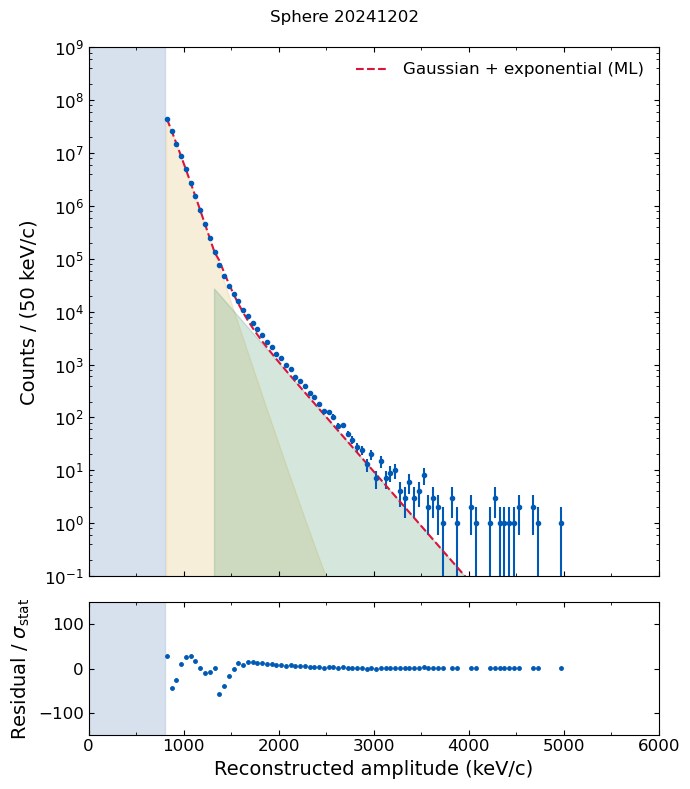

In [1584]:
fig, axes = plt.subplots(2, 1, figsize=(7, 8), height_ratios=[4, 1])

ntot = np.sum(hist)
alpha, mu, m, n, b, xi = res.x

idx = bc > 800
hist_norm = n_window * scaling

hist_fit_ls = hist_norm * np.exp(func_fit_expo(bc[idx], popt_expo[0], popt_expo[1], popt_expo[2]))
hist_fit_ml = hist_fit_likelihood(bc[idx], np.sum(hist), *res.x)

ax = axes[0]
ax.fill_betweenx(np.logspace(-1, 9, 100), 0, 800, color='#B0C4DE', alpha=0.5)
ax.errorbar(bc[idx], hist[idx], yerr=np.sqrt(hist[idx]), fmt='.', color='#005AB5', alpha=1)

# ax.plot(bc[idx], hist_fit_ls, '--', color='#E1BE6A', label='Gaussian + exponential (LS)')
ax.plot(bc[idx], hist_fit_ml, '--', color='#DC143C', label='Gaussian + exponential (ML)')


xx2 = np.linspace(820, 10000, 500)
gaus_hist = ntot * 50 * alpha * half_gaus_mod(xx2, mu, m, n)
ax.fill_between(xx2, 0, gaus_hist, color='#E1BE6A', alpha=0.25)

xx1 = np.linspace(b, 10000, 500)
expo_hist = ntot * 50 * (1 - alpha) * expo_corrected(xx1, b, xi, eff_coefs=None)
ax.fill_between(xx1, 0, expo_hist, color='#2E8B57', alpha=0.2)

ax.set_yscale('log')
# ax.set_xscale('log')

ax.set_xlim(0, 6000)
ax.set_ylim(1e-1, 1e9)

ax.set_yticks(np.logspace(-1, 9, 11))
locmin = LogLocator(base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=15)
ax.xaxis.set_minor_locator(MultipleLocator(500))
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(NullFormatter())

ax.legend(frameon=False)
ax.set_xticklabels([''])
ax.set_ylabel('Counts / (50 keV/c)')

ax = axes[1]
# ax.plot(bc[idx], (hist[idx] - hist_fit_ls) / np.sqrt(hist[idx]), '--', color='#E1BE6A', label='Gaussian + exponential (LS)')
ax.plot(bc[idx], (hist[idx] - hist_fit_ml) / np.sqrt(hist[idx]), '.', color='#005AB5', markersize=5, label='Gaussian + exponential (ML)')
ax.fill_betweenx(np.linspace(-1000, 1000, 100), 0, 800, color='#B0C4DE', alpha=0.5)

ax.set_xlim(0, 6000)
ax.set_ylim(-150, 150)
ax.xaxis.set_minor_locator(MultipleLocator(500))
ax.set_xlabel('Reconstructed amplitude (keV/c)')
ax.set_ylabel('Residual / $\sigma_{\mathrm{stat}}$')

fig.suptitle('Sphere 20241202')
fig.tight_layout()

In [ ]:
R_um       = 0.083
mx_list    = np.logspace(-2, 5, 40)
alpha_list = np.logspace(-10, -4, 40)
mphi = 1

In [ ]:
mx = mx_list[15]
qq, drdq, drdqz, drdqzn = [[] for i in range(4)]
for alpha in alpha_list:
    file = f'/Users/yuhan/work/impulse/yuhan/data/mphi_1e+00/drdqz_nanosphere_{R_um:.2e}_{mx:.5e}_{alpha:.5e}_{mphi:.0e}.h5py'
    with h5py.File(file, 'r') as f:
        g = f['dm_rate_sampled']
        try:
            qq.append(g.attrs['bin_center_kev'])
        except(KeyError):
            qq.append(g['bin_center_kev'][:])
        drdq.append(g['rate_binned_iso'][:])
        drdqz.append(g['rate_binned_z'][:])
        drdqzn.append(g['rate_binned_z_gaus'][:])

Text(0.5, 0, 'Momentum transfer $q_z$ (keV/c)')

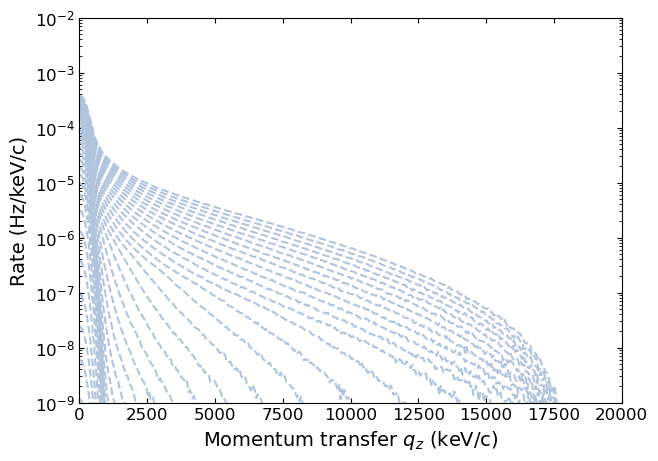

In [ ]:
for i in range(0, 40):
    # plt.plot(qq[i], drdq[i], 'r--')
    # plt.plot(qq[i], drdqz[i], 'g--')
    plt.plot(qq[i], drdqzn[i], '--', color='#B0C4DE')

plt.yscale('log')
plt.ylim(1e-9, 1e-2)
plt.xlim(0, 20000)

plt.ylabel('Rate (Hz/keV/c)')
plt.xlabel('Momentum transfer $q_z$ (keV/c)')

In [1546]:
def read_dm_rate(mphi, mx, alpha):
    R_um       = 0.083
    file = f'/Users/yuhan/work/impulse/yuhan/data/mphi_1e+00/drdqz_nanosphere_{R_um:.2e}_{mx:.5e}_{alpha:.5e}_{mphi:.0e}.h5py'
    with h5py.File(file, 'r') as f:
        g = f['dm_rate_sampled']

        try:
            qq = g.attrs['bin_center_kev']
        except(KeyError):
            qq = g['bin_center_kev'][:]
        
        drdqzn = g['rate_binned_z_gaus'][:]
    return qq, drdqzn

def nll_dm(alpha, mu, m, n, b, xi, bc, hist, eff_coefs, mphi, mx, alpha_n, hist_norm):
    qq, drdqzn = read_dm_rate(mphi, mx, alpha_n)
    eff_qq = func2(qq, *eff_coefs)
    hist_dm = eff_qq * drdqzn * hist_norm

    # For large dm couplings that give large kicks
    # zero pad the actual measured histogram
    if qq.size > bc.size:
        hist = np.pad(hist, (0, qq.size - bc.size))
        bc = qq

    idx = bc > 800

    bi = bc[idx]
    ni = hist[idx]

    # Total number of count in the entire range
    # DM events are fixed so profile over other parameters
    ntot = np.sum(hist) - np.sum(hist_dm)

    # Use only the central value of pdf
    # faster and avoid numerical issues from integration
    # No correctiion for efficiency for the background
    joint_pdf = alpha * half_gaus_mod(bi, mu, m, n) + (1 - alpha) * expo_corrected(bi, b, xi, eff_coefs=None)
    mui = ntot * joint_pdf * 50 + hist_dm[idx]

    return np.sum(np.nan_to_num(mui - ni * np.log(mui)))

In [ ]:
ntot = np.sum(hist)
args = (bc, hist, None)
res = minimize(fun=lambda x: nll(*x, *args), x0=[0.9999, 100, 3e-2, 280, 1215, 200],
               method='COBYQA',
               bounds=[(0.99, 1), (0, 300), (0, 0.1), (150, 300), (1000, 1500), (100, 230)],
               options={'disp' : True,
                        'maxfev': 5000,
                        'maxiter': 5000,
                        'scale': True
                        }
               )

In [1547]:
nll = []
for alpha in alpha_list:
    nll.append(nll_dm(*res.x, bc, hist, eff_coefs, mphi, mx_list[15], alpha, hist_norm))

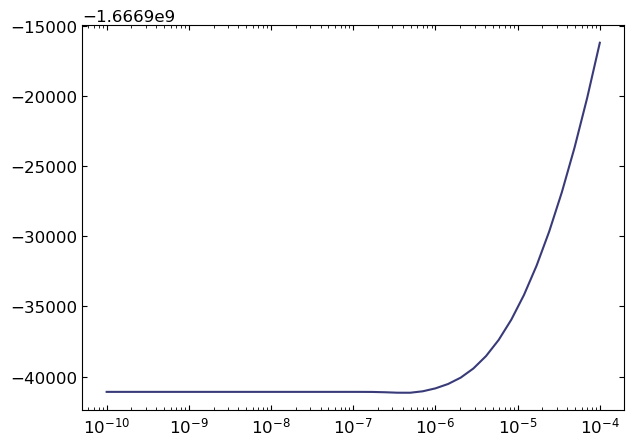

In [1557]:
plt.plot(alpha_list, np.asarray(nll))
plt.xscale('log')

In [1551]:
np.argmin(nll)

24

In [1552]:
alpha_list[24]

4.923882631706742e-07

## Read in the calculated rate

In [1403]:
R_um       = 0.083
mx_list    = np.logspace(-2, 5, 40)
alpha_list = np.logspace(-10, -4, 40)
mphi = 1

In [1446]:
mx = mx_list[15]
qq, drdq = [], []
for alpha in alpha_list:
    file = f'/Users/yuhan/work/impulse/yuhan/data/mphi_1e+00/drdq_nanosphere_{R_um:.2e}_{mx:.5e}_{alpha:.5e}_{mphi:.0e}.npz'
    drdq_npz = np.load(file)

    qq.append(drdq_npz['q_kev'])
    drdq.append(drdq_npz['drdq_hz_kev'])

alpha = alpha_list[19]
qq_1, drdq_1 = [], []
for mx in mx_list:
    file = f'/Users/yuhan/work/impulse/yuhan/data/mphi_1e+00/drdq_nanosphere_{R_um:.2e}_{mx:.5e}_{alpha:.5e}_{mphi:.0e}.npz'
    drdq_npz = np.load(file)

    qq_1.append(drdq_npz['q_kev'])
    drdq_1.append(drdq_npz['drdq_hz_kev'])


## Project the event rate onto the $z$-axis

In [ ]:
i = 20
_qq, _drdq_smoothed = qq[i], np.nan_to_num( np.exp(savgol_filter(np.log(drdq[i]), 50, 1)), nan=0 )

/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_64558/1812468859.py:2: RuntimeWarning: divide by zero encountered in log
  _qq, _drdq_smoothed = qq[i], np.nan_to_num( np.exp(savgol_filter(np.log(drdq[i]), 50, 1)), nan=0 )


In [ ]:
rand_seed = 22040403
rng = np.random.default_rng(rand_seed)

def get_random_q_samples(qq, drdq, rr):
    norm_factor = np.trapz(drdq, qq)

    f_drdq_norm = drdq / norm_factor       # PDF of q
    Fc_drdq_norm = np.cumsum(f_drdq_norm)  # CDF of q

    qq_sampled = np.interp(rr, Fc_drdq_norm, qq, left=0, right=0)
    return qq_sampled, norm_factor


In [ ]:
n_mc = int(1e8)

rr = rng.uniform(0, 1, n_mc)
phiphi = rng.uniform(0, np.pi, n_mc)
noise_gaussian = rng.normal(0, 200, n_mc)

In [ ]:
qq_sampled, norm = get_random_q_samples(_qq, _drdq_smoothed, rr)

hh, be   = np.histogram(qq_sampled, bins=np.arange(0, 5000, 50), density=True)
hhz, be  = np.histogram(qq_sampled*np.abs(np.cos(phiphi)), bins=np.arange(0, 5000, 50), density=True)
hhzn, be = np.histogram(qq_sampled*np.abs(np.cos(phiphi)) + noise_gaussian, bins=np.arange(0, 5000, 50), density=True)
bc = 0.5 * (be[1:] + be[:-1])

Text(0, 0.5, '$dR / dq$ (Hz/keV/c)')

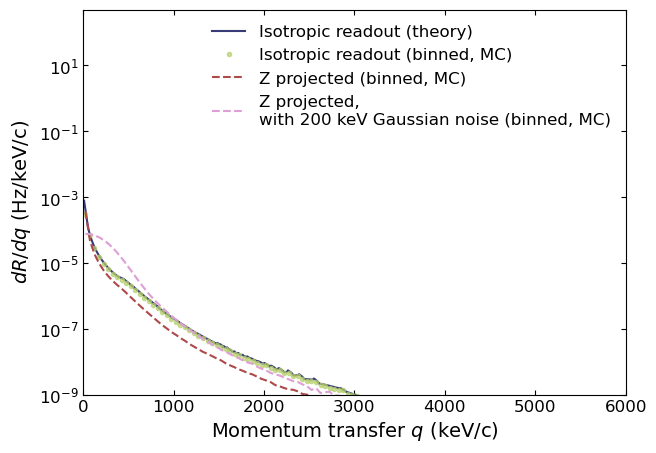

In [ ]:
colors = plt.colormaps.get_cmap('tab20b').resampled(4).colors
fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(_qq, _drdq_smoothed, '-', color=colors[0], label=f'Isotropic readout (theory)')
ax.plot(bc, hh*norm, '.', color=colors[1], alpha=0.7, label='Isotropic readout (binned, MC)')
ax.plot(bc, hhz*norm, '--', color=colors[2], label='Z projected (binned, MC)')
ax.plot(bc, hhzn*norm, '--', color=colors[3], label='Z projected, \nwith 200 keV Gaussian noise (binned, MC)')

ax.legend(frameon=False)

ax.set_ylim(1e-9, 500)
ax.set_xlim(0, 6000)
ax.set_yscale('log')
# ax.set_xscale('log')

ax.set_xlabel('Momentum transfer $q$ (keV/c)')
ax.set_ylabel('$dR / dq$ (Hz/keV/c)')

## Incorrect implementation!

<>:9: SyntaxWarning: invalid escape sequence '\c'
<>:9: SyntaxWarning: invalid escape sequence '\p'
<>:9: SyntaxWarning: invalid escape sequence '\c'
<>:9: SyntaxWarning: invalid escape sequence '\p'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_64558/3117880255.py:9: SyntaxWarning: invalid escape sequence '\c'
  ax.set_title(f'$M_\chi$ = {mx_list[14]:.1f} GeV, $\\alpha_n$ = {alpha_list[i]:.1e}, $m_\phi$ = 1 eV')
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_64558/3117880255.py:9: SyntaxWarning: invalid escape sequence '\p'
  ax.set_title(f'$M_\chi$ = {mx_list[14]:.1f} GeV, $\\alpha_n$ = {alpha_list[i]:.1e}, $m_\phi$ = 1 eV')


Text(0, 0.5, '$dR / dq$ (Hz/keV/c)')

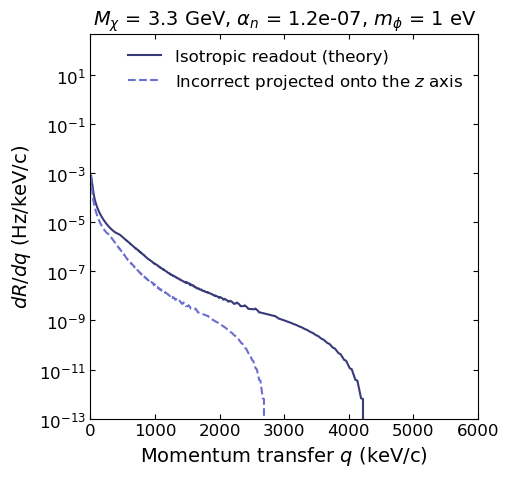

In [ ]:
# Because <|cos theta|> = 2 / pi if theta is uniformly 
# distributed from 0 to pi
# This is incorrected! Because the tail should remain the same

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(_qq, _drdq_smoothed, '-' ,label=f'Isotropic readout (theory)')
ax.plot(_qq * 2 / np.pi, _drdq_smoothed, '--' ,label=f'Incorrect projected onto the $z$ axis')

ax.set_title(f'$M_\chi$ = {mx_list[14]:.1f} GeV, $\\alpha_n$ = {alpha_list[i]:.1e}, $m_\phi$ = 1 eV')
ax.legend(frameon=False)

ax.set_ylim(1e-13, 500)
ax.set_xlim(0, 6000)
ax.set_yscale('log')

ax.set_xlabel('Momentum transfer $q$ (keV/c)')
ax.set_ylabel('$dR / dq$ (Hz/keV/c)')

<>:14: SyntaxWarning: invalid escape sequence '\c'
<>:27: SyntaxWarning: invalid escape sequence '\c'
<>:27: SyntaxWarning: invalid escape sequence '\p'
<>:28: SyntaxWarning: invalid escape sequence '\p'
<>:14: SyntaxWarning: invalid escape sequence '\c'
<>:27: SyntaxWarning: invalid escape sequence '\c'
<>:27: SyntaxWarning: invalid escape sequence '\p'
<>:28: SyntaxWarning: invalid escape sequence '\p'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_64558/1630405506.py:14: SyntaxWarning: invalid escape sequence '\c'
  axes[1].plot(qq_1[i]*2/np.pi, np.exp(savgol_filter(np.log(drdq_1[i]), 50, 1)), '--', label=f'$M_\chi$ = {mx_list[i]:.1f} GeV')
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_64558/1630405506.py:27: SyntaxWarning: invalid escape sequence '\c'
  axes[0].set_title(f'$M_\chi$ = {mx_list[15]:.1f} GeV, $m_\phi$ = 1 eV')
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_64558/1630405506.py:27: SyntaxWarning: invalid escape sequence '\p'
  axes[0

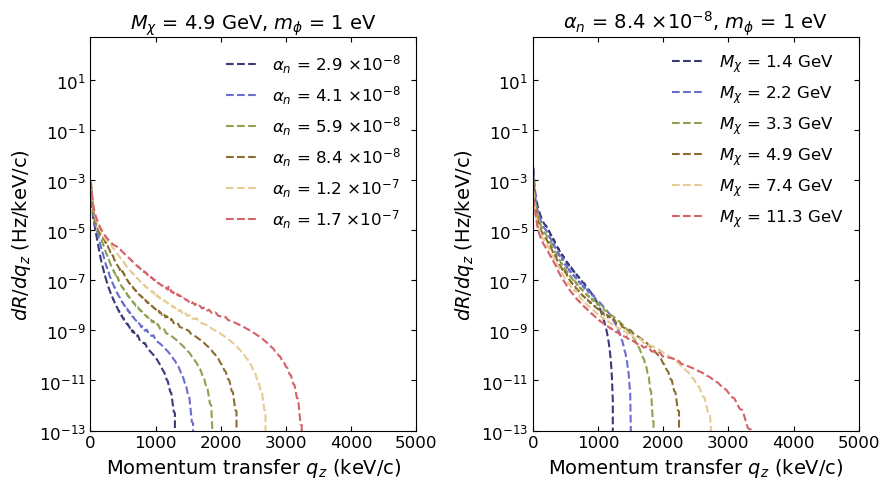

In [ ]:
# Plot the calculated event rate projected onto the z axis
# Smooth with a second order filter in the log space for plotting

fig, axes = plt.subplots(1, 2, figsize=(9, 5))

for i in range(16, 22):
    if alpha_list[i] > 1e-7:
        alpha_label = f'$\\alpha_n$ = {alpha_list[i]/1e-7:.1f} $\\times 10^{{-7}}$'
    else:
        alpha_label = f'$\\alpha_n$ = {alpha_list[i]/1e-8:.1f} $\\times 10^{{-8}}$'
    axes[0].plot(qq[i]*2/np.pi, np.exp(savgol_filter(np.log(drdq[i]), 50, 1)), '--' ,label=alpha_label)

for i in range(12, 18):
    axes[1].plot(qq_1[i]*2/np.pi, np.exp(savgol_filter(np.log(drdq_1[i]), 50, 1)), '--', label=f'$M_\chi$ = {mx_list[i]:.1f} GeV')

for ax in axes:
    ax.legend(frameon=False)
    ax.set_yscale('log')
    # ax.set_xscale('log')
    ax.set_ylim(1e-13, 500)
    ax.set_xlim(0, 5000)

    ax.set_xlabel('Momentum transfer $q_z$ (keV/c)')
    ax.set_ylabel('$dR / dq_z$ (Hz/keV/c)')

axes[0].set_title(f'$M_\chi$ = {mx_list[15]:.1f} GeV, $m_\phi$ = 1 eV')
axes[1].set_title(f'$\\alpha_n$ = {alpha_list[19]/1e-8:.1f} $\\times 10^{{-8}}$, $m_\phi$ = 1 eV')

fig.tight_layout()

plt.savefig('/Users/yuhan/work/nanospheres/paper_plots/dm_nanospheres/dm_rate_drdqz.pdf', dpi=600)
